# 03 — EDA (Exploratory Data Analysis)

**Scop:** înțeleg distribuțiile, trendurile, topurile și anomaliile după curățare.
**Date:** `data/processed/sales_clean.parquet` (din pasul 02).
**Întrebări-cheie:**
- Ce distribuții au prețurile și cantitățile?
- Cum evoluează vânzările în timp?
- Care sunt top produsele/magazinele?
- Există efect vizibil al promoțiilor?
- Unde apar outlieri?


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PROCESSED = Path("data/processed")
df = pd.read_parquet(PROCESSED/"sales_clean.parquet")

# asigur tipurile
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["effective_price"] = pd.to_numeric(df["effective_price"], errors="coerce")
df["quantity"] = pd.to_numeric(df["quantity"], errors="coerce")
df["line_amount"] = pd.to_numeric(df["line_amount"], errors="coerce")

df.shape, df.dtypes.head()


((683, 20),
 trans_id               object
 timestamp      datetime64[ns]
 customer_id            object
 product_id             object
 quantity              float64
 dtype: object)

In [2]:
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib"])


0

**Nota:** `effective_price` = `promo_price` când promo activă, altfel `unit_price`. `line_amount` = `effective_price * quantity`.


In [2]:
display(df.head(3))
display(df.describe(include="all").T.head(12))

missing = df.isna().mean().sort_values(ascending=False)
missing.head(10)


,trans_id,timestamp,customer_id,product_id,quantity,unit_price,store,payment_method,product_name,category,unit,list_price,vat,customer_name,email,city,segment,promo_price,effective_price,line_amount
0,T313725,2025-07-14 11:28:00,C2127,P1010,2.0,21.22,,None,Ceai Eco,Bauturi,buc,21.93,0.09,Andrei Radu,user3327@example.ro,Iasi,B2C,NaN,21.22,42.44
1,T426596,2025-04-23 10:55:00,C2189,P1003,3.0,14.02,Store-01,None,Suc Zero,Dulciuri,set,16.36,NaN,Elena Marin,user1087@example.ro,Brasov,RETAIL,NaN,14.02,42.06
2,T797849,2025-08-16 01:08:00,C2057,P1053,3.0,38.66,shop_03,None,Apa Premium,-,buc,38.16,0.05,George Radu,user4647@example.ro,Cluj-Napoca,B2C,NaN,38.66,115.98


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
trans_id,683,675,T790632,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
timestamp,683,NaN,NaN,NaN,2025-05-19 16:38:32.064421632,2025-01-01 02:05:00,2025-03-13 02:18:00,2025-05-18 06:31:00,2025-07-22 07:24:30,2025-09-28 18:31:00,NaN
customer_id,683,234,C2026,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_id,683,60,P1001,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quantity,683.0,NaN,NaN,NaN,3.619327,1.0,1.0,2.0,5.0,10.0,3.147178
unit_price,683.0,NaN,NaN,NaN,30.802401,3.14,17.96,31.45,42.76,59.93,15.586213
store,683,5,Online,161,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_method,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_name,683,39,Ceai Max,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,683,5,Dulciuri,224,NaN,NaN,NaN,NaN,NaN,NaN,NaN


promo_price       1.000000
payment_method    1.000000
vat               0.172767
email             0.070278
product_id        0.000000
customer_id       0.000000
timestamp         0.000000
trans_id          0.000000
product_name      0.000000
quantity          0.000000
dtype: float64

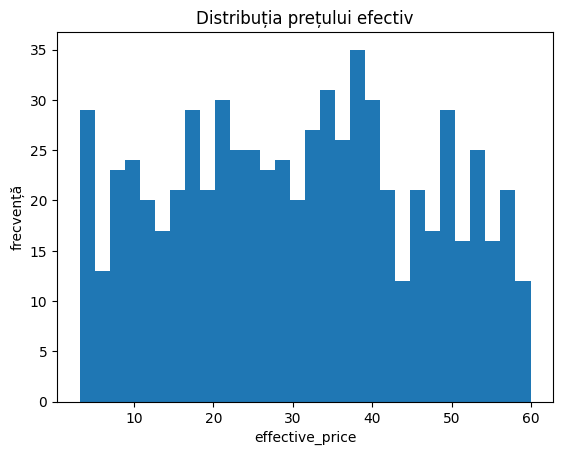

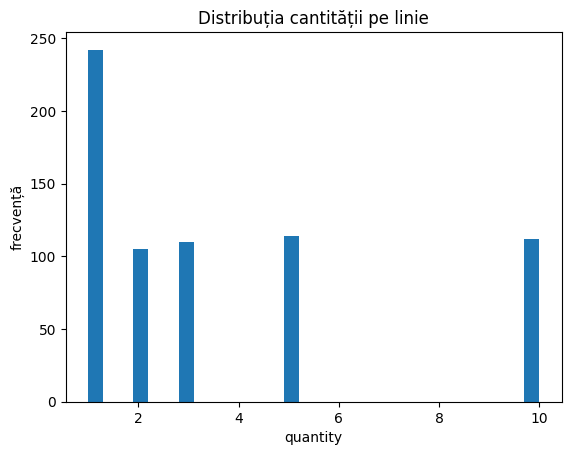

In [3]:
# Distribuția prețului efectiv
df["effective_price"].plot(kind="hist", bins=30)
plt.title("Distribuția prețului efectiv")
plt.xlabel("effective_price")
plt.ylabel("frecvență")
plt.show()

# Distribuția cantităților
df["quantity"].plot(kind="hist", bins=30)
plt.title("Distribuția cantității pe linie")
plt.xlabel("quantity")
plt.ylabel("frecvență")
plt.show()


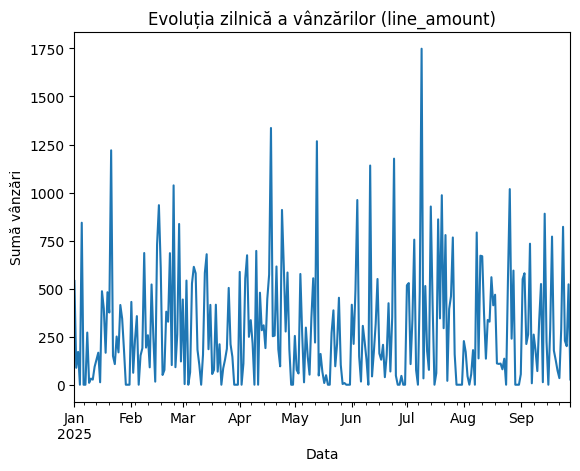

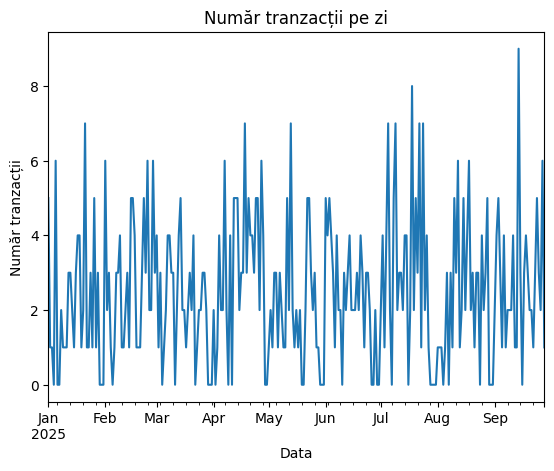

In [4]:
# vânzări zilnice (suma valorii)
daily = (df.set_index("timestamp")
           .resample("D")["line_amount"].sum()
           .fillna(0))

daily.plot()
plt.title("Evoluția zilnică a vânzărilor (line_amount)")
plt.xlabel("Data")
plt.ylabel("Sumă vânzări")
plt.show()

# număr tranzacții / zi
cnt = (df.set_index("timestamp")
         .resample("D")["trans_id"].nunique()
         .fillna(0))

cnt.plot()
plt.title("Număr tranzacții pe zi")
plt.xlabel("Data")
plt.ylabel("Număr tranzacții")
plt.show()


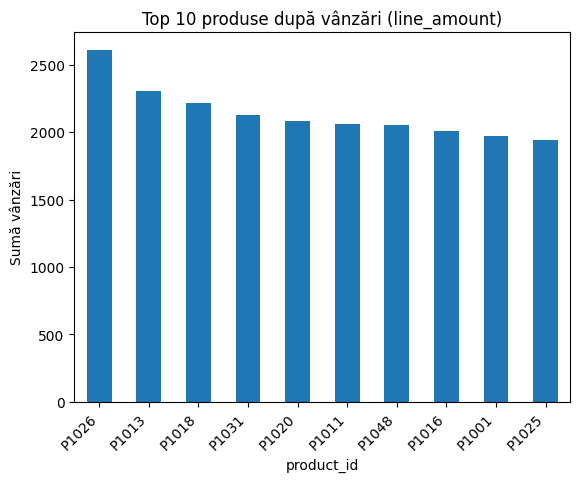

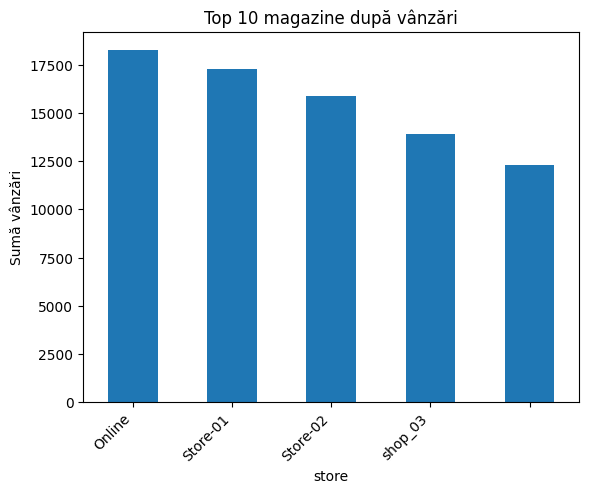

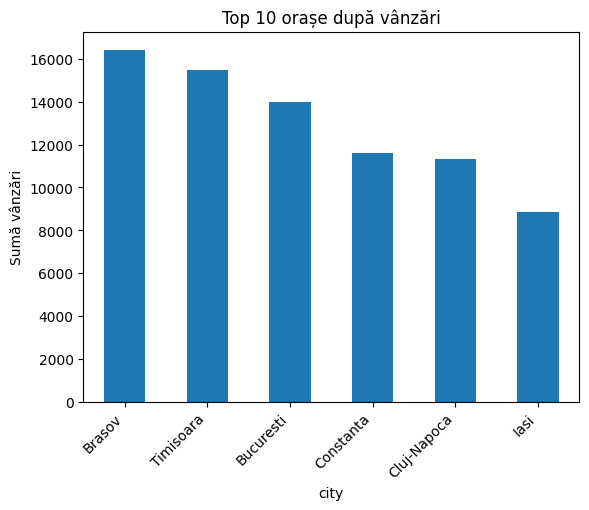

In [5]:
# Top 10 produse după sumă vândută
top_prod = df.groupby("product_id")["line_amount"].sum().sort_values(ascending=False).head(10)
top_prod.plot(kind="bar")
plt.title("Top 10 produse după vânzări (line_amount)")
plt.xlabel("product_id")
plt.ylabel("Sumă vânzări")
plt.xticks(rotation=45, ha="right")
plt.show()

# Top 10 magazine
by_store = df.groupby("store")["line_amount"].sum().sort_values(ascending=False).head(10)
by_store.plot(kind="bar")
plt.title("Top 10 magazine după vânzări")
plt.xlabel("store")
plt.ylabel("Sumă vânzări")
plt.xticks(rotation=45, ha="right")
plt.show()

# Top orașe (dacă ai city în customers)
if "city" in df.columns:
    by_city = df.groupby("city")["line_amount"].sum().sort_values(ascending=False).head(10)
    by_city.plot(kind="bar")
    plt.title("Top 10 orașe după vânzări")
    plt.xlabel("city")
    plt.ylabel("Sumă vânzări")
    plt.xticks(rotation=45, ha="right")
    plt.show()


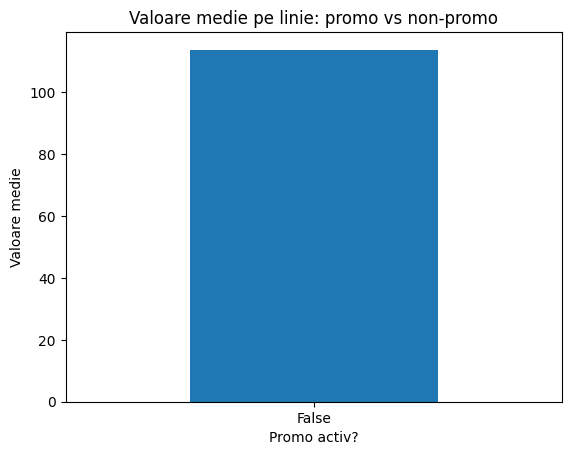

is_promo,False
product_id,
P1001,29.074000
P1003,33.591250
P1010,31.355556
P1016,31.952941
P1042,24.946875


In [6]:
# Marchez promo vs non-promo (după existența promo_price)
df["is_promo"] = df["promo_price"].notna()

# Medie preț efectiv pe promo vs non-promo
df.groupby("is_promo")["effective_price"].mean()

# Vânzări medii / tranzacție promo vs non-promo
avg_line = df.groupby("is_promo")["line_amount"].mean()
avg_line.plot(kind="bar")
plt.title("Valoare medie pe linie: promo vs non-promo")
plt.xlabel("Promo activ?")
plt.ylabel("Valoare medie")
plt.xticks(rotation=0)
plt.show()

# Compar preț efectiv pe același produs, promo vs nu (top 5 produse)
top5 = df["product_id"].value_counts().head(5).index
sub = df[df["product_id"].isin(top5)]
pivot = sub.pivot_table(index="product_id", columns="is_promo", values="effective_price", aggfunc="mean")
pivot


In [8]:
# Box-like check cu quantile
q = df["effective_price"].quantile([0.01, 0.99]).values
mask_out_price = (df["effective_price"] < q[0]) | (df["effective_price"] > q[1])
out_price = df.loc[mask_out_price, ["product_id","effective_price","quantity","timestamp"]].head(10)
out_price

q2 = df["quantity"].quantile([0.01, 0.99]).values
mask_out_qty = (df["quantity"] < q2[0]) | (df["quantity"] > q2[1])
out_qty = df.loc[mask_out_qty, ["product_id","effective_price","quantity","timestamp"]].head(10)
out_qty


,product_id,effective_price,quantity,timestamp


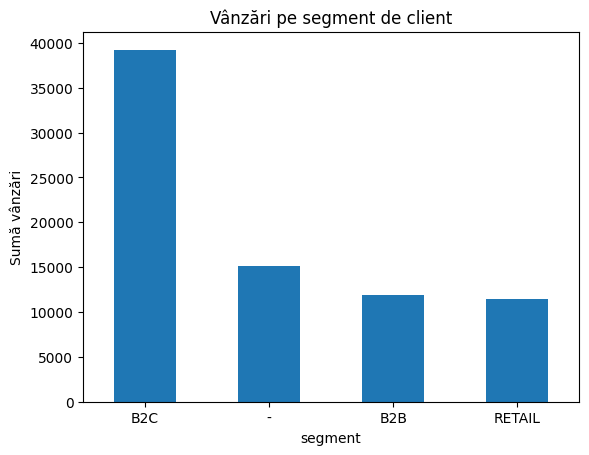

In [9]:
if "segment" in df.columns:
    seg = df.groupby("segment")["line_amount"].sum().sort_values(ascending=False)
    seg.plot(kind="bar")
    plt.title("Vânzări pe segment de client")
    plt.xlabel("segment")
    plt.ylabel("Sumă vânzări")
    plt.xticks(rotation=0)
    plt.show()


In [10]:
# tabele utile
out_dir = Path("reports")
out_dir.mkdir(exist_ok=True)

top_prod.to_csv(out_dir/"top_products.csv")
by_store.to_csv(out_dir/"sales_by_store.csv")
daily.to_csv(out_dir/"sales_daily.csv")

# salvează imagini (re-randare rapidă dacă vrei)
ax = daily.plot()
plt.title("Evoluția zilnică a vânzărilor")
plt.xlabel("Data"); plt.ylabel("Sumă vânzări")
plt.tight_layout()
plt.savefig(out_dir/"daily_sales.png")
plt.close()
"Saved to reports/"


'Saved to reports/'

In [11]:
import pandas as pd
import numpy as np

kpis = {
    "valoare_totală": df["line_amount"].sum(),
    "nr_tranzacții_unice": df["trans_id"].nunique(),
    "nr_linii": len(df),
    "ticket_mediu_pe_tranzacție": df.groupby("trans_id")["line_amount"].sum().mean(),
    "preț_mediu": df["effective_price"].mean(),
    "cantitate_medie_pe_linie": df["quantity"].mean(),
    "clienți_unici": df["customer_id"].nunique(),
    "produse_unice": df["product_id"].nunique(),
    "magazine_unice": df["store"].nunique(),
}
pd.Series(kpis)


valoare_totală                77680.840000
nr_tranzacții_unice             675.000000
nr_linii                        683.000000
ticket_mediu_pe_tranzacție      115.082726
preț_mediu                       30.802401
cantitate_medie_pe_linie          3.619327
clienți_unici                   234.000000
produse_unice                    60.000000
magazine_unice                    5.000000
dtype: float64

In [12]:
top_prod = df.groupby("product_id")["line_amount"].sum().sort_values(ascending=False)
top_store = df.groupby("store")["line_amount"].sum().sort_values(ascending=False)
top_city  = df.groupby("city")["line_amount"].sum().sort_values(ascending=False)

def share_top(series, n=5):
    total = series.sum()
    return (series.head(n).sum() / total) if total else np.nan

pd.Series({
    "Top5 produse %": share_top(top_prod, 5),
    "Top5 magazine %": share_top(top_store, 5),
    "Top5 orașe %": share_top(top_city, 5),
})


Top5 produse %     0.146056
Top5 magazine %    1.000000
Top5 orașe %       0.886207
dtype: float64

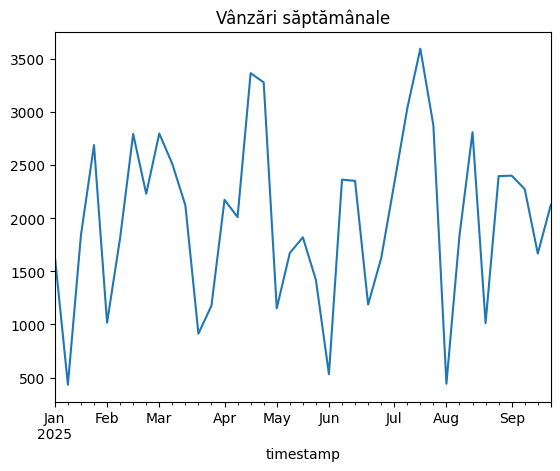

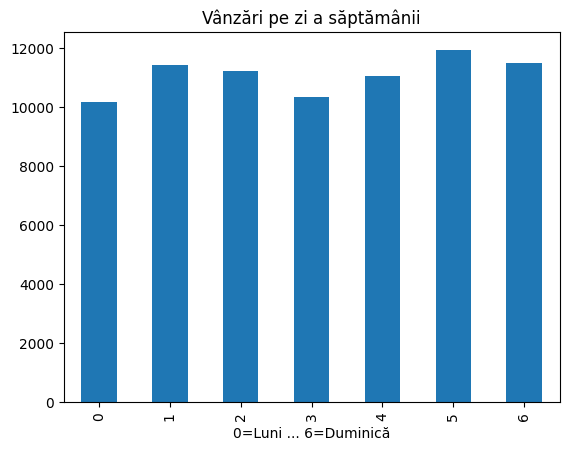

In [13]:
# vânzări pe săptămână
weekly = (df.set_index("timestamp")["line_amount"]
            .resample("W-SUN").sum().fillna(0))
weekly.plot(); plt.title("Vânzări săptămânale"); plt.show()

# zi a săptămânii (0=Luni ... 6=Duminică)
dow = df.copy()
dow["dow"] = dow["timestamp"].dt.dayofweek
dow.groupby("dow")["line_amount"].sum().plot(kind="bar")
plt.title("Vânzări pe zi a săptămânii"); plt.xlabel("0=Luni ... 6=Duminică"); plt.show()


In [14]:
df["is_promo"] = df["promo_price"].notna()

coverage = df["is_promo"].mean()
avg_qty   = df.groupby("is_promo")["quantity"].mean()
avg_line  = df.groupby("is_promo")["line_amount"].mean()
avg_price = df.groupby("is_promo")["effective_price"].mean()

summary_promo = pd.DataFrame({
    "coverage_%": [coverage],
    "qty_avg_noPromo": [avg_qty.get(False, np.nan)],
    "qty_avg_Promo":   [avg_qty.get(True, np.nan)],
    "line_avg_noPromo":[avg_line.get(False, np.nan)],
    "line_avg_Promo":  [avg_line.get(True, np.nan)],
    "price_avg_noPromo":[avg_price.get(False, np.nan)],
    "price_avg_Promo":  [avg_price.get(True, np.nan)],
})
summary_promo


,coverage_%,qty_avg_noPromo,qty_avg_Promo,line_avg_noPromo,line_avg_Promo,price_avg_noPromo,price_avg_Promo
0,0.0,3.619327,NaN,113.734758,NaN,30.802401,NaN


In [15]:
def pct_lift(a, b):
    return (b - a) / a * 100 if pd.notna(a) and a != 0 else np.nan

pd.Series({
    "Lift qty % (Promo vs noPromo)":  pct_lift(avg_qty.get(False,np.nan),  avg_qty.get(True,np.nan)),
    "Lift line % (Promo vs noPromo)": pct_lift(avg_line.get(False,np.nan), avg_line.get(True,np.nan)),
    "Δ preț % (Promo vs noPromo)":    pct_lift(avg_price.get(False,np.nan),avg_price.get(True,np.nan)),
})


Lift qty % (Promo vs noPromo)    NaN
Lift line % (Promo vs noPromo)   NaN
Δ preț % (Promo vs noPromo)      NaN
dtype: float64

In [16]:
def iqr_bounds(s):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    low = q1 - 1.5*iqr
    high = q3 + 1.5*iqr
    return low, high

for col in ["effective_price","quantity"]:
    low, high = iqr_bounds(df[col].dropna())
    print(col, "bounds:", low, "—", high, " | outliers:", ((df[col]<low)|(df[col]>high)).sum())


effective_price bounds: -19.240000000000002 — 79.96000000000001  | outliers: 0
quantity bounds: -5.0 — 11.0  | outliers: 0


In [17]:
from pathlib import Path
reports = Path("reports"); reports.mkdir(exist_ok=True)

pd.Series(kpis).to_csv(reports/"kpi_summary.csv")
top_prod.head(20).to_csv(reports/"top_products.csv")
top_store.to_csv(reports/"sales_by_store.csv")
top_city.to_csv(reports/"sales_by_city.csv")
summary_promo.to_csv(reports/"promo_summary.csv", index=False)
weekly.to_csv(reports/"weekly_sales.csv")

with open(reports/"INSIGHTS.md","w", encoding="utf-8") as f:
    f.write("# Insights EDA\n\n")
    for k,v in kpis.items():
        f.write(f"- **{k.replace('_',' ')}**: {v:,.2f}\n")


In [18]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === datele curățate (din pasul 02) ===
PROCESSED = Path("data/processed")
df = pd.read_parquet(PROCESSED/"sales_clean.parquet").copy()

# tipuri corecte (de siguranță)
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
for c in ["effective_price","quantity","line_amount"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# === KPI-uri ===
kpis = {
    "valoare_totală": df["line_amount"].sum(),
    "nr_tranzacții_unice": df["trans_id"].nunique(),
    "nr_linii": len(df),
    "ticket_mediu_pe_tranzacție": df.groupby("trans_id")["line_amount"].sum().mean(),
    "preț_mediu": df["effective_price"].mean(),
    "cantitate_medie_pe_linie": df["quantity"].mean(),
    "clienți_unici": df["customer_id"].nunique(),
    "produse_unice": df["product_id"].nunique(),
    "magazine_unice": df["store"].nunique(),
}

# === Topuri & serii temporale ===
top_prod  = df.groupby("product_id")["line_amount"].sum().sort_values(ascending=False)
top_store = df.groupby("store")["line_amount"].sum().sort_values(ascending=False)
top_city  = df.groupby("city")["line_amount"].sum().sort_values(ascending=False) if "city" in df.columns else pd.Series(dtype=float)

daily  = df.set_index("timestamp")["line_amount"].resample("D").sum().fillna(0)
weekly = df.set_index("timestamp")["line_amount"].resample("W-SUN").sum().fillna(0)

# === Promo impact ===
df["is_promo"] = df["promo_price"].notna()
cov_promo = df["is_promo"].mean()
avg_qty   = df.groupby("is_promo")["quantity"].mean()
avg_line  = df.groupby("is_promo")["line_amount"].mean()
avg_price = df.groupby("is_promo")["effective_price"].mean()

def pct_lift(a, b):
    return (b - a) / a * 100 if pd.notna(a) and a != 0 else np.nan

lift_qty  = pct_lift(avg_qty.get(False,np.nan),  avg_qty.get(True,np.nan))
lift_line = pct_lift(avg_line.get(False,np.nan), avg_line.get(True,np.nan))
lift_price= pct_lift(avg_price.get(False,np.nan),avg_price.get(True,np.nan))

# === Outlieri IQR ===
def iqr_bounds(s):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    return q1 - 1.5*iqr, q3 + 1.5*iqr

out_summary = {}
for col in ["effective_price","quantity"]:
    low, high = iqr_bounds(df[col].dropna())
    out_summary[col] = int(((df[col] < low) | (df[col] > high)).sum())

# === Salvăm artefactele ===
reports = Path("reports")
reports.mkdir(exist_ok=True)

# tabele CSV
pd.Series(kpis).to_csv(reports/"kpi_summary.csv")
top_prod.head(20).to_csv(reports/"top_products.csv")
top_store.to_csv(reports/"sales_by_store.csv")
if not top_city.empty:
    top_city.to_csv(reports/"sales_by_city.csv")
daily.to_csv(reports/"sales_daily.csv")
weekly.to_csv(reports/"sales_weekly.csv")

# grafice PNG (1 plot / figură)
ax = daily.plot()
plt.title("Evoluția zilnică a vânzărilor")
plt.xlabel("Data"); plt.ylabel("Sumă vânzări"); plt.tight_layout()
plt.savefig(reports/"daily_sales.png"); plt.close()

ax = weekly.plot()
plt.title("Vânzări săptămânale")
plt.xlabel("Săptămână"); plt.ylabel("Sumă vânzări"); plt.tight_layout()
plt.savefig(reports/"weekly_sales.png"); plt.close()

top_prod.head(10).plot(kind="bar")
plt.title("Top 10 produse după vânzări"); plt.xlabel("product_id"); plt.ylabel("Sumă vânzări")
plt.xticks(rotation=45, ha="right"); plt.tight_layout()
plt.savefig(reports/"top10_products.png"); plt.close()

top_store.head(10).plot(kind="bar")
plt.title("Top 10 magazine după vânzări"); plt.xlabel("store"); plt.ylabel("Sumă vânzări")
plt.xticks(rotation=45, ha="right"); plt.tight_layout()
plt.savefig(reports/"top10_stores.png"); plt.close()

if not top_city.empty:
    top_city.head(10).plot(kind="bar")
    plt.title("Top 10 orașe după vânzări"); plt.xlabel("city"); plt.ylabel("Sumă vânzări")
    plt.xticks(rotation=45, ha="right"); plt.tight_layout()
    plt.savefig(reports/"top10_cities.png"); plt.close()

# === Raport Markdown auto-generat ===
def fmt(x): 
    return f"{x:,.2f}" if isinstance(x, (float, np.floating)) else f"{x:,}"

md = []
md.append("# EDA Summary\n")
md.append("Artefacte generate automat din `03_eda.ipynb`.\n")

md.append("## KPIs\n")
for k,v in kpis.items():
    md.append(f"- **{k.replace('_',' ').title()}**: {fmt(v)}")

md.append("\n## Topuri\n")
md.append("- **Top 10 produse**: vezi `reports/top10_products.png` și `reports/top_products.csv`.")
md.append("- **Top 10 magazine**: vezi `reports/top10_stores.png` și `reports/sales_by_store.csv`.")
if not top_city.empty:
    md.append("- **Top 10 orașe**: vezi `reports/top10_cities.png` și `reports/sales_by_city.csv`.")

md.append("\n## Trenduri\n")
md.append("- Evoluție zilnică: `reports/daily_sales.png`.")
md.append("- Evoluție săptămânală: `reports/weekly_sales.png`.")

md.append("\n## Promoții\n")
md.append(f"- **Acoperire promo**: {cov_promo*100:,.1f}% din linii.")
md.append(f"- **Lift cantitate (Promo vs non-Promo)**: {lift_qty:,.1f}%")
md.append(f"- **Lift valoare/linie (Promo vs non-Promo)**: {lift_line:,.1f}%")
md.append(f"- **Δ preț mediu (Promo vs non-Promo)**: {lift_price:,.1f}%")

md.append("\n## Outlieri (IQR)\n")
for k,v in out_summary.items():
    md.append(f"- {k}: {v} rânduri potențial outlier")

md.append("\n## Reproducere\n")
md.append("1. Rulează `01_collect_merge.ipynb` → `02_cleaning.ipynb` → `03_eda.ipynb`.")
md.append("2. Artefactele apar în folderul `reports/` (CSV + PNG + acest rezumat).")

(reports/"EDA_SUMMARY.md").write_text("\n".join(md), encoding="utf-8")
"Raport și artefacte scrise în folderul 'reports/'."


"Raport și artefacte scrise în folderul 'reports/'."